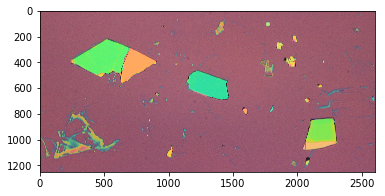

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

import sys

sys.path.append("/Users/Spencer/PycharmProjects/PieceRecognizer")

import sampleData

import spencerUtilities

bn = sampleData.smallBn()

plt.imshow(bn)

bnGray = sampleData.rgb2gray(bn)

In [6]:
from skimage.feature import canny

In [7]:
edges = canny(bnGray)

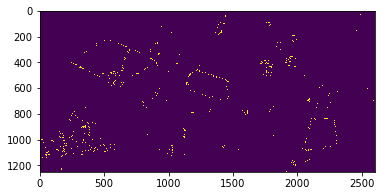

In [8]:
plt.imshow(edges)

In [9]:
from skimage.morphology import dilation

In [10]:
dilatedEdgesList = [edges]

In [11]:
for i in range(6):
    edges = dilation(edges)
    dilatedEdgesList.append(edges)

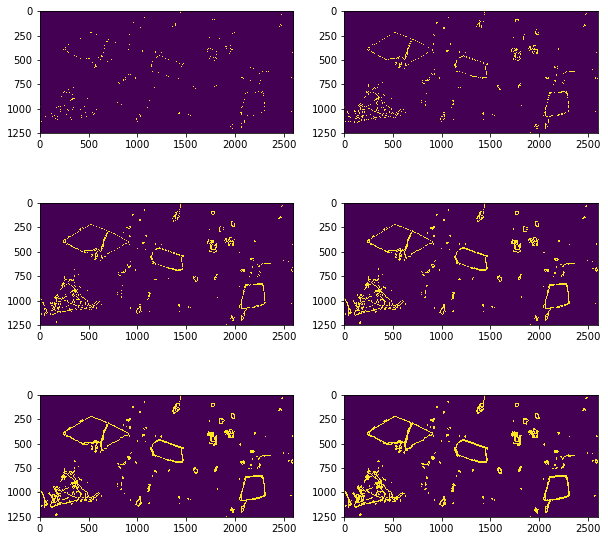

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()
for i in range(6):
    axes[i].imshow(dilatedEdgesList[i])

In [13]:
dilated = dilatedEdgesList[5]

In [14]:
from scipy import ndimage as ndi
fill_holes = ndi.binary_fill_holes(dilated)

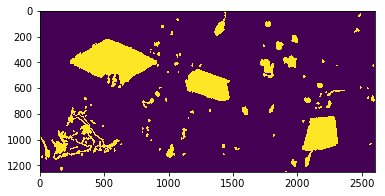

In [15]:
plt.imshow(fill_holes)

In [16]:
from skimage.measure import label, regionprops

In [17]:
labelImage = label(fill_holes)

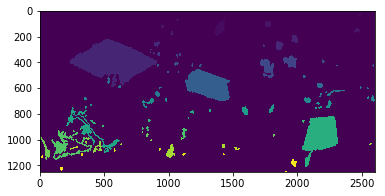

In [18]:
plt.imshow(labelImage)

In [19]:
import numpy as np

In [20]:
labelImageFiltered = np.zeros_like(labelImage)
for region in regionprops(labelImage):
    if region.area > 12000:
        for coord in region.coords:
            x = coord[0]
            y = coord[1]
            labelImageFiltered[x, y] = 1
        


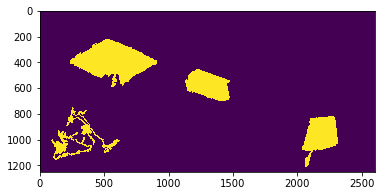

In [21]:
plt.imshow(labelImageFiltered)

the arbitrary bit about this is the number of dilations to apply. Plus, notice that the tape residue is now connected. Maybe filtering based on holes or Euler's number might do the trick. Another problem is that information about the crack in the large piece of BN to the upper left, which is visible after dilation, is lost when the regions are filled--this should be remediable.

Let's try something else! Watershed
====

In [22]:
from skimage.filters import sobel
elevation_map = sobel(bnGray)

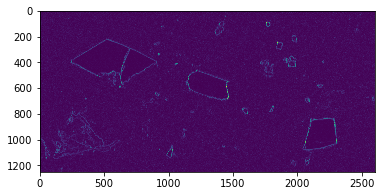

In [23]:
plt.imshow(elevation_map)

In [24]:
histogram, _ = np.histogram(bnGray, range=(0, 1), bins=255)

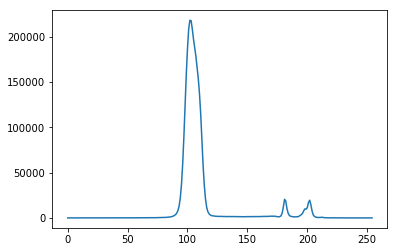

In [25]:
plt.plot(histogram)

In [26]:
integral = np.cumsum(histogram)

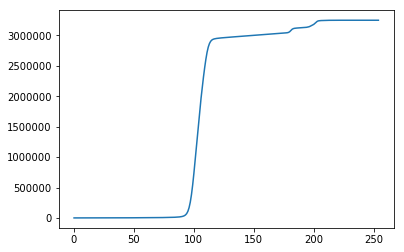

In [27]:
plt.plot(integral)

In [28]:
totalPixels = integral[-1]

In [29]:
normalized = integral/totalPixels

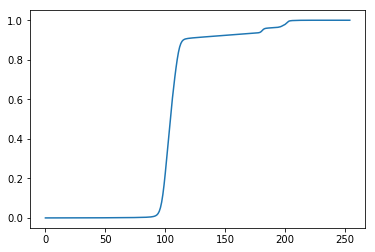

In [30]:
plt.plot(normalized)

In [31]:
upper = 0
lower = 0
lowerWeight = 0.01
upperWeight = 0.99
for i in range(len(normalized)):
    if normalized[i] > lowerWeight:
        lower = i
        break
        
for j in range(1, len(normalized)+1):
    if normalized[-j] < upperWeight:
        upper = 256 - j
        break

In [32]:
upper

202

In [33]:
lower

92

In [34]:
markers = np.zeros_like(bnGray)

In [35]:
markers[bnGray < lower/255] = 1
markers[bnGray > upper/255] = 2

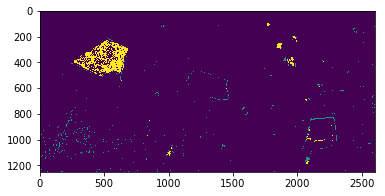

In [36]:
plt.imshow(markers)

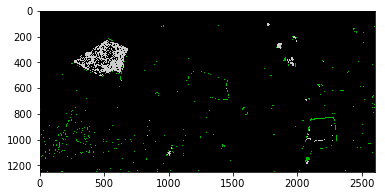

In [37]:
plt.imshow(markers, cmap='nipy_spectral')

In [38]:
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)

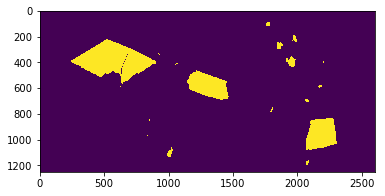

In [39]:
plt.imshow(segmentation)

This works hella well!

In [40]:
labelImageWatershed = label(segmentation)

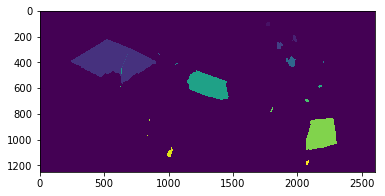

In [41]:
plt.imshow(labelImageWatershed)

In [42]:
labelImageFilteredWatershed = np.zeros_like(labelImageWatershed)
regions = regionprops(labelImageWatershed)
# we have to remove the largest region, which is the background. But actually, we could use this to compute the
# background intensity.
regions.sort(key=lambda region: region.area)
regions.pop()
for region in regions:
    if region.area > 12000:
        for coord in region.coords:
            x = coord[0]
            y = coord[1]
            labelImageFilteredWatershed[x, y] = 1

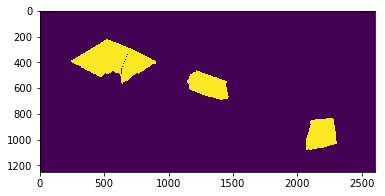

In [43]:
plt.imshow(labelImageFilteredWatershed)

Yup, still works great! Plus the crack is still visible. Perhaps a few rounds of erosion would show the two separate regions.

As a final test, let me try applying this method to the small graphite sample:
===

In [44]:
gr = sampleData.smallGraphene()

In [45]:
ggr = sampleData.rgb2gray(gr)

In [46]:
histogram, _ = np.histogram(ggr, range=(0, 1), bins=255)

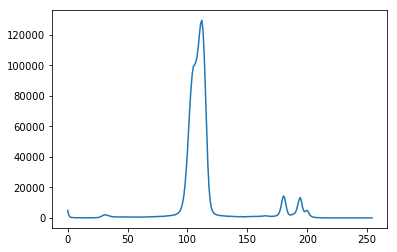

In [47]:
plt.plot(histogram)

In [48]:
integral = np.cumsum(histogram)

In [49]:

totalPixels = integral[-1]

normalized = integral/totalPixels


In [50]:
def findUpperAndLowerBounds(normalizedHistogram, lowerWeight, upperWeight):
    upper = 0
    lower = 0
    for i in range(len(normalized)):
        if normalized[i] > lowerWeight:
            lower = i
            break

    for j in range(1, len(normalized)+1):
        if normalized[-j] < upperWeight:
            upper = 256 - j
            break
    
    return (lower, upper)

In [87]:
lower, upper = findUpperAndLowerBounds(normalized, 0.01, 0.99)

In [97]:
100./255

0.39215686274509803

In [89]:
def makeMarkers(image, upper, lower, lowerMean, upperMean):
    markers = np.zeros_like(image)

    markers[np.logical_and(lowerMean < image, image < upperMean)] = 1
    markers[np.logical_or(image > upper, image < lower)] = 2
    return markers

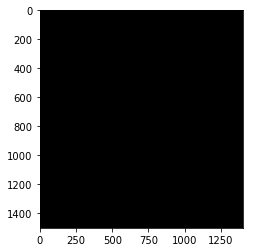

In [98]:
plt.imshow(np.logical_or(ggr > (100./255), ggr < (120./255)), cmap='nipy_spectral')

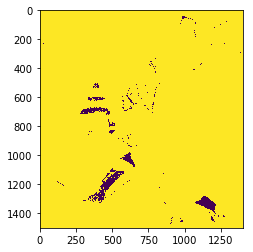

In [91]:
plt.imshow(np.logical_and(34/255 < ggr, ggr < 198/255))

In [92]:
markersGr = makeMarkers(ggr, lower/255, upper/255, 100/255, 120/255)

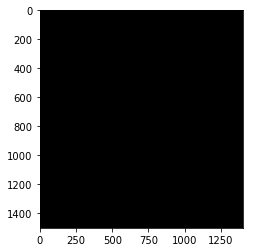

In [93]:
plt.imshow(markersGr, cmap='nipy_spectral')

In [73]:
elevationMapGr = sobel(ggr)

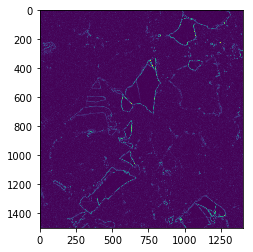

In [74]:
plt.imshow(elevationMapGr)

In [75]:
segmentationGr = watershed(elevationMapGr, markersGr)

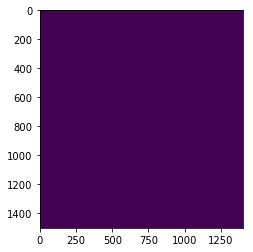

In [77]:
plt.imshow(segmentationGr)

In [ ]:
labelImageGr = label(segmentationGr)

In [ ]:
plt.imshow(labelImageGr)

In [ ]:
plt.imshow(gr)

In [ ]:
def doWatershed(image, lowerWeight, upperWeight):
    histogram, _ = np.histogram(image, range=(0, 1), bins=255)
    integral = np.cumsum(histogram)
    totalPixels = integral[-1]
    normalized = integral/totalPixels
    lower, upper = findUpperAndLowerBounds(normalized, lowerWeight, upperWeight)
    markers = makeMarkers(image, lower/255, upper/255)
    elevationMap = sobel(image)
    segmentation = watershed(elevationMap, markers)
    labelImage = label(segmentation)
    return labelImage

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes=axes.flatten()
for i in range(9):
    axes[i].imshow(doWatershed(ggr, 0.01*i, 1-0.01*i))

Maybe with sufficiently even lighting, such as we seem to have across the really small imaging area, thresholding really is the way to go...

In [ ]:
histogram, _ = np.histogram(ggr, range=(0,1), bins=255)

In [ ]:
plt.plot(histogram)

In [ ]:
def doWatershedWithDilations(image, lowerWeight, upperWeight, numDilations):
    histogram, _ = np.histogram(image, range=(0, 1), bins=255)
    integral = np.cumsum(histogram)
    totalPixels = integral[-1]
    normalized = integral/totalPixels
    lower, upper = findUpperAndLowerBounds(normalized, lowerWeight, upperWeight)
    markers = makeMarkers(image, lower/255, upper/255)
    elevationMap = sobel(image)
    for i in range(numDilations):
        elevationMap = dilation(elevationMap)
    segmentation = watershed(elevationMap, markers)
    labelImage = label(segmentation)
    return (elevationMap, labelImage)

In [ ]:
elevationMap, labelImage = doWatershedWithDilations(ggr, 0.05, 0.95, 5)
plt.imshow(labelImage)

In [ ]:
plt.imshow(elevationMap)

In [ ]:
from skimage.color import rgb2hsv

In [ ]:
hsvGr = rgb2hsv(gr)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
for i in range(3):
    axes[i].imshow(hsvGr[:, :, i])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
for i in range(3):
    axes[i].imshow(doWatershed(hsvGr[:, :, i], 0.05, 0.95))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
for i in range(3):
    axes[i].imshow(doWatershed(hsvGr[:, :, i], 0.20, 0.80))

Rather than using extremal points as markers, I'd like to use patches of uniform color such as we have in these images. Waaaaiit... can I use local extrema as markers?

In [ ]:
from skimage.morphology import local_minima, local_maxima

In [ ]:
def doWatershedLocalExtrema(image):
    mins = local_minima(image)
    maxes = local_maxima(image)
    
    markers = np.zeros_like(image)
    markers[mins] = 1
    markers[maxes] = 2
    
    elevationMap = sobel(image)
    segmentation = watershed(elevationMap, markers)
    labelImage = label(segmentation)
    return (elevationMap, labelImage, markers, mins, maxes)

In [ ]:
e, l, m, mi, ma= doWatershedLocalExtrema(ggr)
plt.imshow(e)

In [ ]:
plt.imshow(l)

In [ ]:
plt.imshow(m, cmap='nipy_spectral')

In [ ]:
plt.imshow(mi)

In [ ]:
plt.imshow(ma)

wow, no I can't. That was a really obviously silly idea.